In [1]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split

# Import Data

In [2]:
#INPUT
file_name = ['results','materials','conditioning','exposure']
file_path = '/Users/meddelinsetiawan/Library/CloudStorage/OneDrive-PrincetonUniversity/Documents/Classes/CBE512/dataset/'
#output_path = ''
header_row = 14 #header's line number in csv file

results_df = pd.read_csv(file_path+file_name[0]+'.csv', delimiter=',')
materials_df = pd.read_csv(file_path+file_name[1]+'.csv')
conditioning_df = pd.read_csv(file_path+file_name[2]+'.csv')
exposure_df = pd.read_csv(file_path+file_name[3]+'.csv')


# Pre-processing

### Results File

Carbonation coefficient (x_0): 0.1767


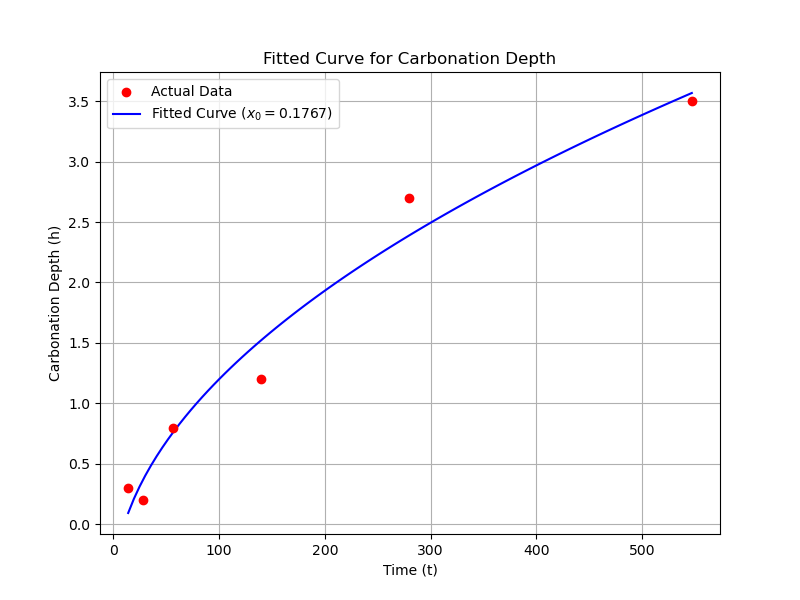

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression

#data19

# Example data: Replace these with your actual h and t values
h = np.array([0.3, 0.2, 0.8,1.2,2.7,3.5])  # Carbonation depth (example)
t = np.array([14, 28, 56, 140,280,547])     # Time (example)

# Transform the data: h = x_0 * sqrt(t)
sqrt_t = np.sqrt(t).reshape(-1, 1)  # Reshape for sklearn
h = h.reshape(-1, 1)

# Perform regression
model = LinearRegression()
model.fit(sqrt_t, h)

# Get the carbonation coefficient (x_0)
x_0 = model.coef_[0][0]  # Slope of the regression line

# Display the result
print(f"Carbonation coefficient (x_0): {x_0:.4f}")

# Generate fitted curve
t_fit = np.linspace(min(t), max(t), 100)  # Generate time values for the curve
sqrt_t_fit = np.sqrt(t_fit)               # Calculate sqrt(t) for curve
h_fit = model.predict(sqrt_t_fit.reshape(-1, 1))  # Predicted h values

# Plot the data and the fitted curve
plt.figure(figsize=(8, 6))
plt.scatter(t, h, color='red', label='Actual Data', zorder=5)  # Actual data points
plt.plot(t_fit, h_fit, color='blue', label=f'Fitted Curve ($x_0 = {x_0:.4f}$)')
plt.xlabel('Time (t)')
plt.ylabel('Carbonation Depth (h)')
plt.title('Fitted Curve for Carbonation Depth')
plt.legend()
plt.grid()
plt.show()

In [4]:
def calc_coefficient(h,t):
    '''
    Perform linear regression of results data points using Fick's diffusion law, and returns the carbonation coefficient
    
    h : carbonation depth
    t : time
    x_0 : carbonation coefficient 
    '''
    sqrt_t = np.sqrt(t).reshape(-1, 1)
    h = h.reshape(-1, 1)
    model = LinearRegression()
    model.fit(sqrt_t, h)
    x_0 = model.coef_[0][0]
    return x_0

def calc_depth(x_0,t):
    '''
    Returns the carbonation depth at a time point based on Fick's diffusion law
    t : time
    x_0 : carbonation coefficient
    '''
    return x_0*np.sqrt(t)

### Feature Space:


In [5]:
#Handle materials feature
print(materials_df.keys())

# Consolidate cement strength class and development into one categorical feature called "cement strength class"
materials_df['Cement Strength Class'] = materials_df['Cement Strength Class'].astype(str) + materials_df['Cement Strength Development']

# Truncate Cement Strength Development, max grain size, grading curve, and kNaC. 
columns_to_remove = ['Cement Strength Development',"Max Grain Size", "Grading Curve", "kNAC", "Unnamed: 14"]
materials_df = materials_df.drop(columns=columns_to_remove)

# Encode categorical labels: cement type, cement strength class, addition type, aggregate type, admixture type.
categorical_features = ['Cement Type', 'Cement Strength Class', 'Addition Type', 'Aggregate Type', 'Admixture Type']
ordinal_encoder = OrdinalEncoder(encoded_missing_value=-1)
materials_df[categorical_features] = ordinal_encoder.fit_transform(materials_df[categorical_features])

#Fill any unfilled space with -1
materials_df = materials_df.fillna(-1)

# Make another materials df that contains only the features required by CarboDB developers
non_required_columns = ['Cement Strength Class','Cement Amount',
       'Addition Type', 'Addition Amount', 'Binder Amount', 'Aggregate Type',
       'Admixture Type']
materials_df_required = materials_df.drop(columns=non_required_columns)
print(materials_df_required.head())

for col, categories in zip(categorical_features, ordinal_encoder.categories_):
    print(f"Mapping for '{col}':")
    for category, encoding in zip(categories, range(len(categories))):
        print(f"  {category} -> {encoding}")
    print()
print(materials_df_required.keys())


Index(['ID', 'Cement Type', 'Cement Strength Class',
       'Cement Strength Development', 'Cement Amount', 'Addition Type',
       'Addition Amount', 'Binder Amount', 'Aggregate Type', 'Admixture Type',
       'Max Grain Size', 'Grading Curve', 'wb ratio', 'kNAC', 'Unnamed: 14'],
      dtype='object')
   ID  Cement Type  wb ratio
0   1          0.0      0.40
1   2          0.0      0.45
2   3          0.0      0.50
3   4          0.0      0.55
4   5          0.0      0.60
Mapping for 'Cement Type':
  CEM I -> 0
  CEM II/A-L -> 1
  CEM II/A-LL -> 2
  CEM II/A-M -> 3
  CEM II/A-S -> 4
  CEM II/A-V -> 5
  CEM II/B-LL -> 6
  CEM II/B-M -> 7
  CEM II/B-S -> 8
  CEM II/B-V -> 9
  CEM III/A -> 10
  CEM III/B -> 11

Mapping for 'Cement Strength Class':
  32.5N -> 0
  32.5R -> 1
  42.5L -> 2
  42.5N -> 3
  42.5R -> 4
  52.5R -> 5

Mapping for 'Addition Type':
  Fly ash -> 0
  LH-HS -> 1
  Limestone -> 2
  S-LL -> 3
  Silica fume -> 4
  Slag -> 5
  T-LL -> 6
  V-LL -> 7
  nan -> 8

Mapping for 

In [6]:
#Handle conditioning features
print(conditioning_df.keys())

conditioning_df = conditioning_df.fillna(-1)

# Make another conditioning df that contains only the features required by CarboDB developers
non_required_columns = ['Demoulding Age', 'Curing Type',
       'Preconditioning Duration', 'Preconditioning Temperature',
       'Preconditioning RH', 'Preconditioning CO2', 'Standard Conditions']
conditioning_df_required = conditioning_df.drop(columns=non_required_columns)
print(conditioning_df_required.keys())
print(conditioning_df_required.head())


Index(['ID', 'Demoulding Age', 'Curing Type', 'Curing Duration',
       'Preconditioning Duration', 'Preconditioning Temperature',
       'Preconditioning RH', 'Preconditioning CO2', 'Standard Conditions'],
      dtype='object')
Index(['ID', 'Curing Duration'], dtype='object')
   ID  Curing Duration
0   1                7
1   2                7
2   3                7
3   4                7
4   5                7


In [7]:
#Handle exposure features
print(exposure_df.keys())

# Truncate 'Time 0 Carbonation Depth deviation' and 'Determination Method'. 
columns_to_remove = ['Time 0 Carbonation Depth deviation','Determination Method']
exposure_df = exposure_df.drop(columns=columns_to_remove)

# Encode categorical labels: cement type, cement strength class, addition type, aggregate type, admixture type.
categorical_features = ['Carbonation Type']
ordinal_encoder = OrdinalEncoder(encoded_missing_value=-1)
exposure_df[categorical_features] = ordinal_encoder.fit_transform(exposure_df[categorical_features])

for col, categories in zip(categorical_features, ordinal_encoder.categories_):
    print(f"Mapping for '{col}':")
    for category, encoding in zip(categories, range(len(categories))):
        print(f"  {category} -> {encoding}")
    print()

exposure_df = exposure_df.fillna(-1) 

# Make another exposure df that contains only the features required by CarboDB developers
non_required_columns = ['Carbonation Begin Age',
       'Time 0 Carbonation Depth average', 'CO2', 'Lab RH', 'Lab Temperature',
       'Field RH', 'Field Temperature', 'Field Storage Type',
       'Field Compass Direction']
exposure_df_required = exposure_df.drop(columns=non_required_columns)

print(exposure_df_required.keys())

Index(['ID', 'Carbonation Type', 'Carbonation Begin Age',
       'Time 0 Carbonation Depth average',
       'Time 0 Carbonation Depth deviation', 'CO2', 'Determination Method',
       'Lab RH', 'Lab Temperature', 'Field RH', 'Field Temperature',
       'Field Storage Type', 'Field Compass Direction'],
      dtype='object')
Mapping for 'Carbonation Type':
  ACC -> 0
  NAC -> 1

Index(['ID', 'Carbonation Type'], dtype='object')


In [8]:
print(materials_df.head())
print(materials_df_required.head())
print(conditioning_df.head())
print(conditioning_df_required.head())
print(exposure_df.head())
print(exposure_df_required.head())

   ID  Cement Type  Cement Strength Class  Cement Amount  Addition Type  \
0   1          0.0                    4.0          320.0           -1.0   
1   2          0.0                    4.0          320.0           -1.0   
2   3          0.0                    4.0          320.0           -1.0   
3   4          0.0                    4.0          320.0           -1.0   
4   5          0.0                    4.0          320.0           -1.0   

   Addition Amount  Binder Amount  Aggregate Type  Admixture Type  wb ratio  
0             -1.0            320            -1.0             1.0      0.40  
1             -1.0            320            -1.0             1.0      0.45  
2             -1.0            320            -1.0             1.0      0.50  
3             -1.0            320            -1.0             1.0      0.55  
4             -1.0            320            -1.0             1.0      0.60  
   ID  Cement Type  wb ratio
0   1          0.0      0.40
1   2          0.0     

**Note here:**

Ordinal encoder was chosen instead of one-hot because it is more suitable for random forest model which treat the integers as categorical splits rather than numerical values. ALso gives more compact representation; fewer columns than one-hot encoding.


# test and train set.

In [9]:
all_features_merged = pd.merge(pd.merge(materials_df,conditioning_df, on='ID', how='outer'), exposure_df, on='ID', how='outer')
print(all_features_merged)

# Drop ID column (not relevant for clustering or PCA) and most NaN features
all_features = all_features_merged.drop(columns=['Admixture Type','Curing Type','Preconditioning CO2', 'Standard Conditions','Field RH', 'Field Temperature', 'Field Storage Type',
       'Field Compass Direction'])

      ID  Cement Type  Cement Strength Class  Cement Amount  Addition Type  \
0      1          0.0                    4.0          320.0           -1.0   
1      2          0.0                    4.0          320.0           -1.0   
2      3          0.0                    4.0          320.0           -1.0   
3      4          0.0                    4.0          320.0           -1.0   
4      5          0.0                    4.0          320.0           -1.0   
..   ...          ...                    ...            ...            ...   
147  149          6.0                    1.0          320.0           -1.0   
148  150          6.0                    1.0          320.0           -1.0   
149  151          6.0                    1.0          320.0           -1.0   
150  152          6.0                    1.0          320.0           -1.0   
151  153          7.0                    3.0          280.0            6.0   

     Addition Amount  Binder Amount  Aggregate Type  Admixture 

In [10]:
# Separate the results data frame into two, based on the number of depth data points
id_counts = results_df['ID'].value_counts()
#depth_time_test = results_df[results_df['ID'].isin(id_counts[id_counts == 2].index)]
depth_time = results_df[results_df['ID'].isin(id_counts[id_counts >= 3].index)]
ids = depth_time['ID'].unique()
features_df = all_features[all_features['ID'].isin(ids)]

features_train, features_test, ids_train, ids_test = train_test_split(features_df, ids, test_size=0.2, random_state=42)
depth_time_test = depth_time[depth_time['ID'].isin(ids_test)]
print(ids_test)
depth_time_test = depth_time_test.drop(columns='Depth deviation [mm]')
depth_time_test['Predicted Depth [mm]'] = None
print(depth_time_test)
#test_ids = depth_time_test['ID'].unique()
#train_ids = depth_time_train['ID'].unique()
print(features_train)

[ 74  59  38  50 138  75  89 128 101  45 118  46  83  23 120 123  55 100
 116 107  37  29 145  30 150  64  90]
      ID  Time [a]  Depth average [mm] Predicted Depth [mm]
40    23        28                 0.3                 None
41    23        56                 0.3                 None
42    23       140                 1.0                 None
43    23       280                 1.1                 None
76    29        28                 1.2                 None
..   ...       ...                 ...                  ...
574  145       140                33.3                 None
588  150       140                 2.8                 None
589  150       235                 3.0                 None
590  150       350                 4.5                 None
591  150       532                 5.5                 None

[121 rows x 4 columns]
      ID  Cement Type  Cement Strength Class  Cement Amount  Addition Type  \
96    98          6.0                    1.0         260.00        

In [11]:
# Make training labels dataset (containing carbonation coefficient)
x_0_train = pd.DataFrame(columns=['ID', 'Carbonation Coefficient (x_0)'])
for id in ids_train:
    subset = depth_time[depth_time['ID'] == id]
    times = subset['Time [a]'].values
    depths = subset['Depth average [mm]'].values
    x_0 = calc_coefficient(depths, times)
    x_0_train = x_0_train.append({'ID': id, 'Carbonation Coefficient (x_0)': x_0}, ignore_index=True)
x_0_train['ID'] = x_0_train['ID'].astype(int)
print(x_0_train.head())

/var/folders/lw/j_ztd_0j18g4j465cmx95hdc0000gn/T/ipykernel_5929/2528254285.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_0_train = x_0_train.append({'ID': id, 'Carbonation Coefficient (x_0)': x_0}, ignore_index=True)
/var/folders/lw/j_ztd_0j18g4j465cmx95hdc0000gn/T/ipykernel_5929/2528254285.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_0_train = x_0_train.append({'ID': id, 'Carbonation Coefficient (x_0)': x_0}, ignore_index=True)
/var/folders/lw/j_ztd_0j18g4j465cmx95hdc0000gn/T/ipykernel_5929/2528254285.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_0_train = x_0_train.append({'ID': id, 'Carbonation Coefficient (x_0)': x_0}, ignore_index=True)
/var/folders/lw/j_ztd_0j18g4j465cmx95hdc0000gn/T/ipykernel

   ID  Carbonation Coefficient (x_0)
0  98                       0.412574
1  66                       0.920306
2  19                       0.176708
3  31                       0.114749
4  61                       0.217040


/var/folders/lw/j_ztd_0j18g4j465cmx95hdc0000gn/T/ipykernel_5929/2528254285.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_0_train = x_0_train.append({'ID': id, 'Carbonation Coefficient (x_0)': x_0}, ignore_index=True)
/var/folders/lw/j_ztd_0j18g4j465cmx95hdc0000gn/T/ipykernel_5929/2528254285.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_0_train = x_0_train.append({'ID': id, 'Carbonation Coefficient (x_0)': x_0}, ignore_index=True)
/var/folders/lw/j_ztd_0j18g4j465cmx95hdc0000gn/T/ipykernel_5929/2528254285.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_0_train = x_0_train.append({'ID': id, 'Carbonation Coefficient (x_0)': x_0}, ignore_index=True)
/var/folders/lw/j_ztd_0j18g4j465cmx95hdc0000gn/T/ipykernel

Model Training

In [12]:
#Drop the 'ID' column
features_for_training = features_train.drop(columns=['ID'])
labels_for_training = x_0_train.drop(columns=['ID'])
features_for_testing = features_test.drop(columns=['ID'])

In [13]:
#Train Model
model_RF = RandomForestRegressor(random_state=42)
model_RF.fit(features_for_training, labels_for_training)
x_0_pred = model_RF.predict(features_for_testing)
predicted_carbon_coefficient = pd.DataFrame({'ID': features_test['ID'], 'Predicted Carbonation Coefficient (x_0)': x_0_pred})

for id in depth_time_test['ID'].unique():  # Loop through each unique ID
    # Get all the rows for the current ID in the depth_time_test dataframe
    id_rows = depth_time_test[depth_time_test['ID'] == id]
    
    for index, row in id_rows.iterrows():
        # Get the corresponding predicted Carbonation Coefficient (x_0)
        x_0 = predicted_carbon_coefficient[predicted_carbon_coefficient['ID'] == id]['Predicted Carbonation Coefficient (x_0)'].iloc[0]
        
        # Get the Time [a] for the current row
        time = row['Time [a]']
        
        # Calculate the predicted depth
        depth_pred = calc_depth(x_0, time)
        
        # Update the Predicted Depth [mm] column for the current row
        depth_time_test.loc[index, 'Predicted Depth [mm]'] = depth_pred
        
        # Print the results for debugging or verification
#        print(id, x_0, time, depth_pred)

mae = mean_absolute_error(depth_time_test['Depth average [mm]'], depth_time_test['Predicted Depth [mm]'])
mse = mean_squared_error(depth_time_test['Depth average [mm]'], depth_time_test['Predicted Depth [mm]'])
rmse = mse ** 0.5
r2 = r2_score(depth_time_test['Depth average [mm]'], depth_time_test['Predicted Depth [mm]'])

# Display results
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-Squared: {r2}")

/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MAE: 1.398280790471665
MSE: 6.9494447520353075
RMSE: 2.6361799544104167
R-Squared: 0.8030243385611004


In [14]:
model_RF = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(model_RF, param_grid, cv=5,
                                 scoring='r2', return_train_score=True)

#grid_search = RandomizedSearchCV(model_RF, param_grid, cv=5, n_iter=100,
#                                 scoring='r2', return_train_score=True)

grid_search.fit(features_for_training, labels_for_training)
best_params = grid_search.best_params_
cv_results = pd.DataFrame(grid_search.cv_results_)

print(cv_results)

/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.052325      0.011601         0.004191        0.000185   
1         0.090139      0.000626         0.006222        0.000102   
2         0.179820      0.005364         0.010543        0.000097   
3         0.042729      0.000707         0.003956        0.000061   
4         0.083358      0.001077         0.006115        0.000070   
..             ...           ...              ...             ...   
103       0.077937      0.000251         0.006062        0.000070   
104       0.153286      0.000678         0.009953        0.000331   
105       0.040319      0.000693         0.004168        0.000111   
106       0.077557      0.000555         0.006111        0.000128   
107       0.157401      0.010918         0.010154        0.000098   

    param_criterion param_min_samples_leaf param_min_samples_split  \
0     squared_error                      1                       2   
1     squared_error            

/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [15]:
print(best_params)

{'criterion': 'squared_error', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [16]:
best_RF_model = RandomForestRegressor(**best_params, random_state=42)
best_RF_model.fit(features_for_training, labels_for_training)
x_0_pred = best_RF_model.predict(features_for_testing)
predicted_carbon_coefficient = pd.DataFrame({'ID': features_test['ID'], 'Predicted Carbonation Coefficient (x_0)': x_0_pred})
for id in depth_time_test['ID'].unique():  # Loop through each unique ID
    # Get all the rows for the current ID in the depth_time_test dataframe
    id_rows = depth_time_test[depth_time_test['ID'] == id]
    
    for index, row in id_rows.iterrows():
        # Get the corresponding predicted Carbonation Coefficient (x_0)
        x_0 = predicted_carbon_coefficient[predicted_carbon_coefficient['ID'] == id]['Predicted Carbonation Coefficient (x_0)'].iloc[0]
        
        # Get the Time [a] for the current row
        time = row['Time [a]']
        
        # Calculate the predicted depth
        depth_pred = calc_depth(x_0, time)
        
        # Update the Predicted Depth [mm] column for the current row
        depth_time_test.loc[index, 'Predicted Depth [mm]'] = depth_pred
        
        # Print the results for debugging or verification
#        print(id, x_0, time, depth_pred)

mae = mean_absolute_error(depth_time_test['Depth average [mm]'], depth_time_test['Predicted Depth [mm]'])
mse = mean_squared_error(depth_time_test['Depth average [mm]'], depth_time_test['Predicted Depth [mm]'])
rmse = mse ** 0.5
r2 = r2_score(depth_time_test['Depth average [mm]'], depth_time_test['Predicted Depth [mm]'])

# Display results
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-Squared: {r2}")

MAE: 1.4473277937776525
MSE: 7.490079379027867
RMSE: 2.7368009388751435
R-Squared: 0.7877005440640735


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [17]:
print(depth_time_test)
print(depth_time_test['Time [a]'].unique())

      ID  Time [a]  Depth average [mm] Predicted Depth [mm]
40    23        28                 0.3             0.499932
41    23        56                 0.3              0.70701
42    23       140                 1.0             1.117882
43    23       280                 1.1             1.580923
76    29        28                 1.2             1.309389
..   ...       ...                 ...                  ...
574  145       140                33.3            23.214573
588  150       140                 2.8             1.945839
589  150       235                 3.0             2.521023
590  150       350                 4.5             3.076642
591  150       532                 5.5             3.793139

[121 rows x 4 columns]
[ 28  56 140 280  98 180 210 465 365  14 310  21 119 235 350 532  42 240
  91 364]


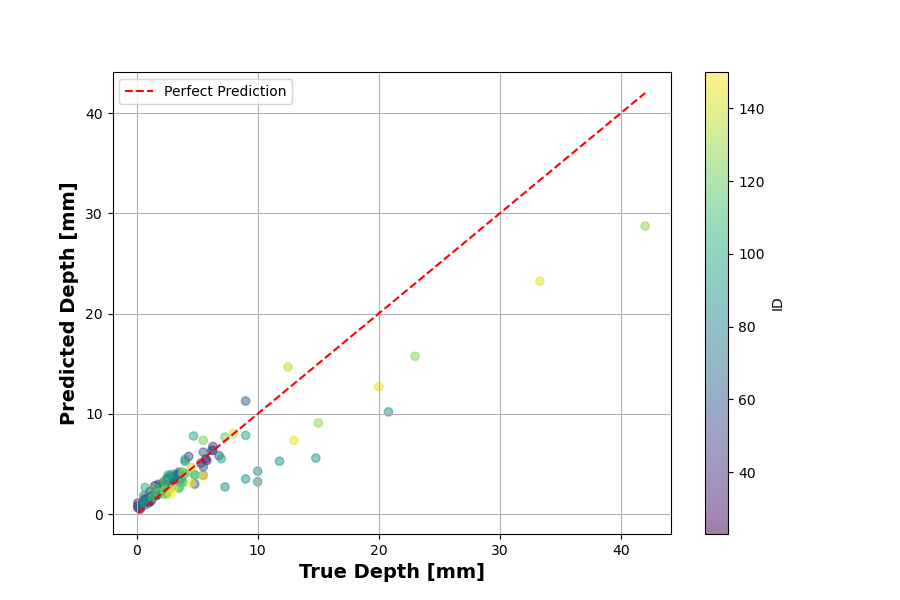

In [18]:
plt.figure(figsize=(9, 6))

scatter = plt.scatter(
    depth_time_test["Depth average [mm]"], 
    depth_time_test["Predicted Depth [mm]"], 
    c=depth_time_test["ID"], 
    cmap="viridis", 
    marker="o", alpha = 0.5
)

# Add colorbar for ID
plt.colorbar(scatter, label="ID")

# Add 45-degree line for reference
min_depth = min(depth_time_test["Depth average [mm]"].min(), depth_time_test["Predicted Depth [mm]"].min())
max_depth = max(depth_time_test["Depth average [mm]"].max(), depth_time_test["Predicted Depth [mm]"].max())
plt.plot([min_depth, max_depth], [min_depth, max_depth], color="red", linestyle="--", label="Perfect Prediction")

# Add labels and title
plt.xlabel("True Depth [mm]", fontsize=14, fontweight="bold")
plt.ylabel("Predicted Depth [mm]", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



In [19]:
print(features_for_training.columns)

Index(['Cement Type', 'Cement Strength Class', 'Cement Amount',
       'Addition Type', 'Addition Amount', 'Binder Amount', 'Aggregate Type',
       'wb ratio', 'Demoulding Age', 'Curing Duration',
       'Preconditioning Duration', 'Preconditioning Temperature',
       'Preconditioning RH', 'Carbonation Type', 'Carbonation Begin Age',
       'Time 0 Carbonation Depth average', 'CO2', 'Lab RH', 'Lab Temperature'],
      dtype='object')


Cement Type: 0.0515
Cement Strength Class: 0.0728
Cement Amount: 0.0147
Addition Type: 0.0019
Addition Amount: 0.0003
Binder Amount: 0.0124
Aggregate Type: 0.0001
wb ratio: 0.0272
Demoulding Age: 0.0000
Curing Duration: 0.0104
Preconditioning Duration: 0.0102
Preconditioning Temperature: 0.0000
Preconditioning RH: 0.0000
Carbonation Type: 0.1890
Carbonation Begin Age: 0.0021
Time 0 Carbonation Depth average: 0.0492
CO2: 0.1525
Lab RH: 0.1928
Lab Temperature: 0.2128


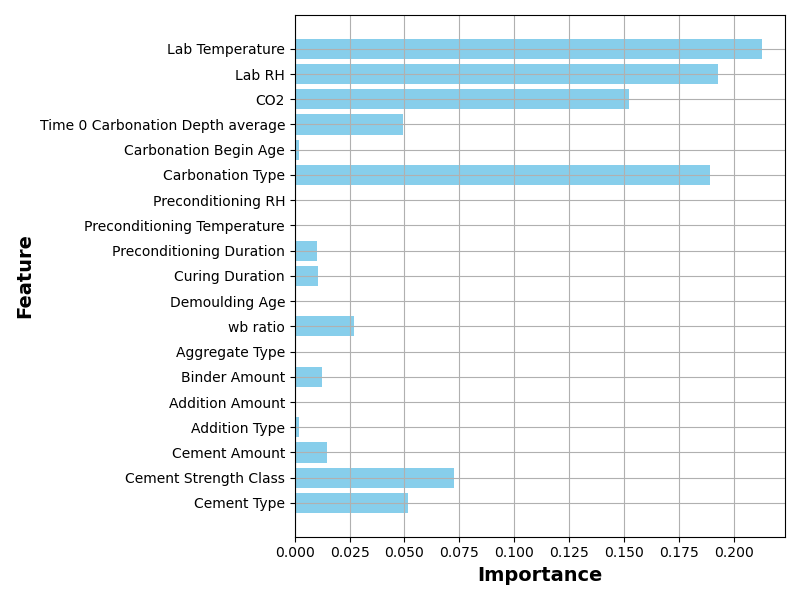

In [20]:
feature_importances = best_RF_model.feature_importances_

# Display feature importance
for feature, importance in zip(features_for_training.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(features_for_training.columns, feature_importances, color="skyblue")
plt.xlabel("Importance", fontsize=14, fontweight="bold")
plt.ylabel("Feature", fontsize=14, fontweight="bold")
plt.grid(True)
plt.tight_layout()
plt.show()

The prediction performance is significantly improved after modifying the train test split. ONly using data that is more than 2 depth_time points, and split 80/20. 

Yeah.. I definitely did not incorporate enough features in the previous model. for example, the ones using superplasticizer definitely have very small coefficient, but my model is predicting because it only loooks at the cement type and water binder ratio. 

Maybe now there is overfitting. 